# Lab 1

## Part 2: Neural Machine Translation in the wild
In the second part of the homework you are supposed to get the best translation you can for the EN-RU translation task.

Basic approach using RNNs as encoder and decoder is implemented for you. 

Your ultimate task is to use the techniques we've covered, e.g.
* [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt)

* CNN encoder (with or without positional encoding)

* attention/self-attention mechanism

* pretraining the language model

* or just fine-tunning BERT)

to improve the translation quality. 

__Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__
Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [1]:
# ! pip  instalschtext

# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

import spacy

import random
import math
import time

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE


### Main part
__Here comes the preprocessing. Do not hesitate to use BPE or more complex preprocessing ;)__

In [3]:
import pandas as pd


In [4]:
data_pd = pd.read_csv('data.txt', sep='\t', header=None)

In [5]:
data_pd

,0,1
0,"Cordelia Hotel is situated in Tbilisi, a 3-min...","Отель Cordelia расположен в Тбилиси, в 3 минут..."
1,At Tupirmarka Lodge you will find a 24-hour fr...,В числе удобств лоджа Tupirmarka круглосуточна...
2,"Featuring free WiFi in all areas, Naigao Xiaow...",Апартаменты Naigao Xiaowo расположены в городе...
3,Each has a TV and a private bathroom with shower.,В вашем распоряжении также телевизор и собстве...
4,Your room comes with air conditioning and sate...,Номер оснащен кондиционером и спутниковым теле...
5,They are styled in cream-coloured hues and som...,"Они оформлены в кремовых тонах, в некоторых из..."
6,The reception team can help guests plan sights...,Сотрудники стойки регистрации с радостью помог...
7,Some units include a seating area for your con...,В числе удобств некоторых номеров — гостиная з...
8,"Nieuwmarkt as well as Kalverstraat, Hermitage ...","До площади Ниумаркт, торговой улицы Калверштра..."
9,The Danube Delta is a natural reserve where yo...,"Дельта Дуная является природным заповедником, ..."


In [6]:
with open('Data/data_prep.ru', 'w') as f_src,  open('Data/data_prep.en', 'w') as f_dst:
    for idx in range(data_pd.shape[0]):
        src_line, dst_line = data_pd[1][idx], data_pd[0][idx]
        f_src.write('. ' + src_line + '\n')
        f_dst.write('. ' + dst_line + '\n')

In [7]:
NYM_SYMBOLS = 10000
bpe = {}
for lang in ['en', 'ru']:
    learn_bpe(open('./Data/data_prep.' + lang), open('Data/bpe_rules.' + lang, 'w'), num_symbols=NYM_SYMBOLS)
    bpe[lang] = BPE(open('./Data/bpe_rules.' + lang))

In [8]:
tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return " ".join(tokenizer.tokenize(x.lower()))

In [9]:
SRC = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token  = '<eos>', 
            lower = True)

TRG = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token  = '<eos>', 
            lower = True)

dataset = torchtext.data.TabularDataset(
    path='data.txt',
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [10]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

In [11]:
# my
for dataset in [train_data, valid_data, test_data]:
    for line in dataset:
        line.src = (bpe['ru'].process_line(line.src)).split(" ")
        line.trg = (bpe['en'].process_line(line.trg)).split(" ")

In [12]:
print(f"Number of training examples:   {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples:    {len(test_data .examples)}")

Number of training examples:   40000
Number of validation examples: 2500
Number of testing examples:    7500


In [13]:
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

In [14]:
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 6090
Unique tokens in target (en) vocabulary: 4567


Here are tokens from original (RU) corpus:

In [15]:
SRC.vocab.itos[::200]

['<unk>',
 'т@@',
 'пар@@',
 'ен@@',
 'ity',
 'park',
 'eri@@',
 '7@@',
 'горнолыжный',
 'ближай@@',
 'гале@@',
 'балками',
 'бре@@',
 '750',
 'химчист@@',
 'паромный',
 'проспекта',
 'просторными',
 'знаменитых',
 'элегантных',
 'еле@@',
 'особня@@',
 'стильных',
 'хорошую',
 'шах@@',
 'etto',
 'ваф@@',
 'нача@@',
 '+@@',
 'колониаль@@',
 'ехать']

And from target (EN) corpus:

In [16]:
TRG.vocab.itos[::100]

['<unk>',
 'desk',
 'kitchenette',
 'golf',
 'décor',
 'ina',
 'are@@',
 'sweet',
 'visiting',
 'est',
 'era',
 'ei@@',
 'cocktails',
 'cooked',
 'hor@@',
 'ach',
 'res@@',
 'ens@@',
 'coun@@',
 'dis@@',
 '43',
 'des@@',
 'iron@@',
 'microwaves',
 'coin',
 'zo',
 'pizz@@',
 'ambi@@',
 'charm',
 'destin@@',
 'forward',
 'bs',
 'bathing',
 'activ@@',
 'sandwi@@',
 'jubl@@',
 'ball@@',
 'stands',
 'ghtful',
 'ù',
 'scuba',
 'paved',
 'hind',
 'dig@@',
 'experien@@',
 'déc@@']

And here is example from train dataset:

In [17]:
print(vars(train_data.examples[9]))

{'trg': ['it', 'offers', 'bike', 'rental', 'and', 'free', 'wi', '-', 'fi', 'access', '.'], 'src': ['в', 'отеле', 'работает', 'прокат', 'велосипедов', 'и', 'предоставляется', 'бесплатный', 'w@@', 'if@@', 'i', '.']}


Let's check the length distributions:

Length distribution in Train data


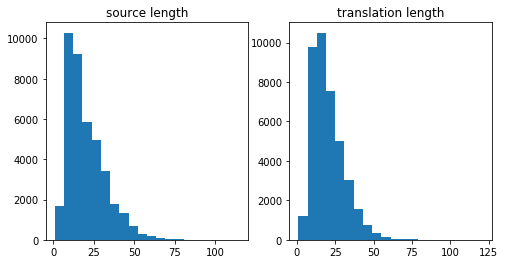

In [18]:
src_length = map(len, [vars(x)['src'] for x in train_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in train_data.examples])

print('Length distribution in Train data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

Length distribution in Test data


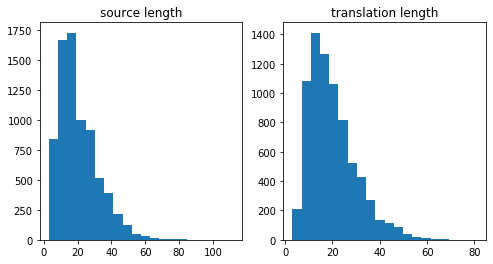

In [19]:
src_length = map(len, [vars(x)['src'] for x in test_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in test_data.examples])

print('Length distribution in Test data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

### Model side
__Here comes simple pipeline of NMT model learning. It almost copies the week03 practice__

In [20]:
device = torch.device('cuda:4' if torch.cuda.is_available() else 'cpu')

In [21]:
device

device(type='cuda', index=4)

In [22]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [23]:
for x in train_iterator:
    break
print(x)
print(x.src.shape, x.trg.shape)


[torchtext.data.batch.Batch of size 128]
	[.trg]:[torch.cuda.LongTensor of size 53x128 (GPU 4)]
	[.src]:[torch.cuda.LongTensor of size 63x128 (GPU 4)]
torch.Size([63, 128]) torch.Size([53, 128])


In [24]:
import my_network
Encoder = my_network.Encoder
Decoder = my_network.Decoder
Seq2Seq = my_network.Seq2Seq

In [25]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)

In [26]:
def init_weights(m):
    # <YOUR CODE HERE>
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(6090, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5)
  )
  (decoder): Decoder(
    (embedding): Embedding(4567, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=512, out_features=4567, bias=True)
    (dropout): Dropout(p=0.5)
  )
)

In [27]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 12,427,479 trainable parameters


In [28]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [29]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

In [30]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [31]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [32]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

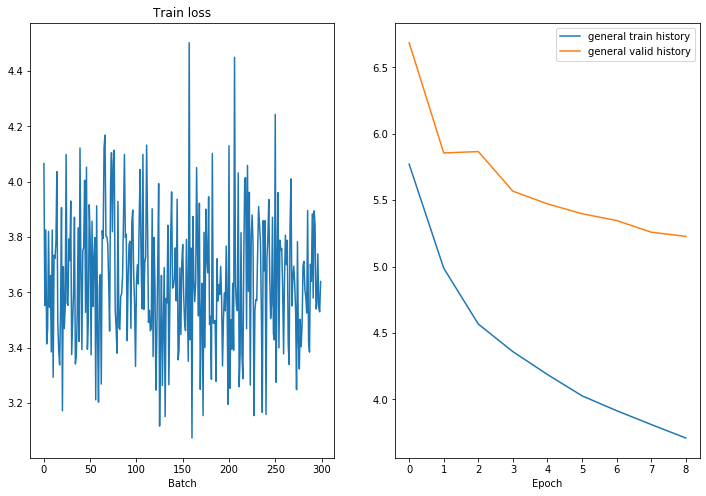

Epoch: 10 | Time: 1m 50s
	Train Loss: 3.643 | Train PPL:  38.190
	 Val. Loss: 5.204 |  Val. PPL: 181.959
CPU times: user 3h 41min 51s, sys: 29min 2s, total: 4h 10min 54s
Wall time: 18min 4s


In [33]:
%%time
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

__Let's take a look at our network quality__:

In [34]:
import utils
import imp
imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

In [35]:
batch = next(iter(test_iterator))

In [36]:
for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: free public parking is available at a location nearby .
Generated: free free private parking on site . . . . .

Original: some units have a balcony .
Generated: some rooms have a private .



In [37]:
from nltk.translate.bleu_score import corpus_bleu

#     """ Estimates corpora-level BLEU score of model's translations given inp and reference out """
#     translations, _ = model.translate_lines(inp_lines, **flags)
#     # Note: if you experience out-of-memory error, split input lines into batches and translate separately
#     return corpus_bleu([[ref] for ref in out_lines], translations) * 100

In [38]:
import tqdm

In [39]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output.detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

59it [00:04, 14.68it/s]


In [40]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

10.239312324442414

Baseline solution BLEU score is quite low. Try to achieve at least __25__ BLEU on the test set. 
The checkpoints are:

* __18__ - minimal score to submit the homework, 30% of points

* __20__ - good score, 70% of points

* __25__ - excellent score, 100% of points